# Model: readers

In [ ]:
#| default_exp model_readers

In [ ]:
#|export
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import torch_scatter
from functools import reduce
import spconv
import spconv.pytorch
from pillarnext_explained.model_utils import SparseConvBlock, SparseBasicBlock

In [ ]:
#|eval: false
#|hide
import matplotlib.pyplot as plt

## Pillar Encoder

In [ ]:
#|export
class PFNLayer(nn.Module):
    """
    Pillar Feature Net Layer.
    The Pillar Feature Net could be composed of a series of these layers, but the PointPillars paper results only
    used a single PFNLayer. This layer performs a similar role as second.pytorch.voxelnet.VFELayer.
    """
    def __init__(self,
                 in_channels: int,  # Number of input channels
                 out_channels: int,  # Number of output channels
                 norm_cfg=None,  # Normalization config (not used here, but could be for future extensions)
                 last_layer: bool = False  # If last_layer, there is no concatenation of features
                 ):
        super().__init__()
        self.last_vfe = last_layer  # Check if this is the last layer
        if not self.last_vfe:
            out_channels = out_channels // 2  # If not the last layer, half the output channels
        self.units = out_channels

        self.linear = nn.Linear(in_channels, out_channels, bias=False)  # Linear layer to transform inputs
        self.norm = nn.BatchNorm1d(out_channels, eps=1e-3, momentum=0.01)  # Batch normalization

    def forward(self, inputs, unq_inv):
        torch.backends.cudnn.enabled = False  # Disable cuDNN for compatibility reasons
        x = self.linear(inputs)  # Apply linear transformation
        x = self.norm(x)  # Apply batch normalization
        x = F.relu(x)  # Apply ReLU activation
        torch.backends.cudnn.enabled = True  # Re-enable cuDNN

        # max pooling
        feat_max = torch_scatter.scatter_max(x, unq_inv, dim=0)[0]  # Perform scatter max pooling
        x_max = feat_max[unq_inv]  # Gather the max features for each point

        if self.last_vfe:
            return x_max  # If this is the last layer, return the max features
        else:
            x_concatenated = torch.cat([x, x_max], dim=1)  # Otherwise, concatenate the original and max features
            return x_concatenated  # Return the concatenated features

Input shape: torch.Size([10, 64])
Unique inverse shape: torch.Size([10])
Output shape: torch.Size([10, 128])


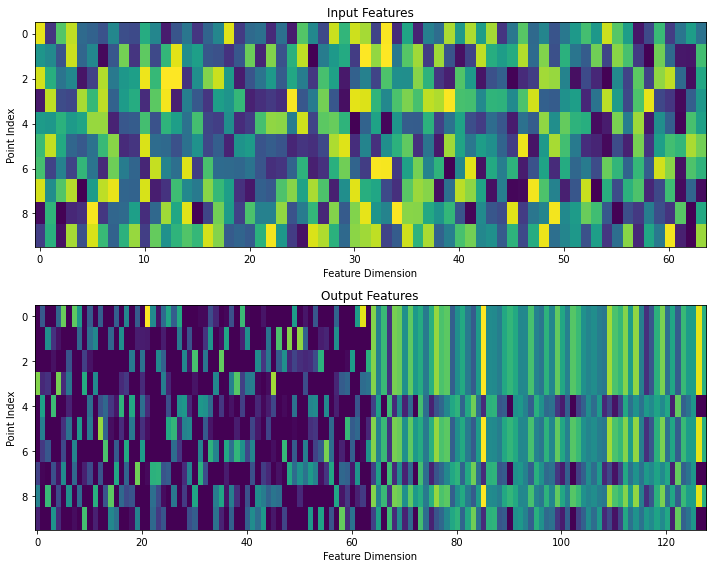

In [ ]:
#|eval: false
# Example data
inputs = torch.rand(10, 64)
unq_inv = torch.randint(0, 2, (10,))


print(f'Input shape: {inputs.shape}')
print(f'Unique inverse shape: {unq_inv.shape}')

# Initialize PFNLayer
pfn_layer = PFNLayer(in_channels=64, out_channels=128, last_layer=False)

# Forward pass
output = pfn_layer(inputs, unq_inv)

print(f'Output shape: {output.shape}')

# Plot input features and output features
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].imshow(inputs.numpy(), aspect='auto', cmap='viridis')
ax[0].set_title('Input Features')
ax[0].set_xlabel('Feature Dimension')
ax[0].set_ylabel('Point Index')

ax[1].imshow(output.detach().numpy(), aspect='auto', cmap='viridis')
ax[1].set_title('Output Features')
ax[1].set_xlabel('Feature Dimension')
ax[1].set_ylabel('Point Index')

plt.tight_layout()
plt.show()


In [ ]:
#|export
class PillarNet(nn.Module):
    """
    PillarNet.
    The network performs dynamic pillar scatter that convert point cloud into pillar representation
    and extract pillar features

    Reference:
    PointPillars: Fast Encoders for Object Detection from Point Clouds (https://arxiv.org/abs/1812.05784)
    End-to-End Multi-View Fusion for 3D Object Detection in LiDAR Point Clouds (https://arxiv.org/abs/1910.06528)
    """

    def __init__(self,
                 num_input_features: int, # Number of input features
                 voxel_size: list, # Size of voxels, only utilize x and y size
                 pc_range: list, # Point cloud range, only utilize x and y min
                 ):
        super().__init__()
        self.voxel_size = np.array(voxel_size)
        self.pc_range = np.array(pc_range)

    def forward(self,
                points: torch.Tensor # Points in LiDAR coordinate, shape: (N, d), format: batch_id, x, y, z, feat1, ...
                ):

        device = points.device
        dtype = points.dtype

        # discard out of range points
        grid_size = (self.pc_range[3:] - self.pc_range[:3]
                     )/self.voxel_size  # x,  y, z
        grid_size = np.round(grid_size, 0, grid_size).astype(np.int64)

        voxel_size = torch.from_numpy(
            self.voxel_size).type_as(points).to(device)
        pc_range = torch.from_numpy(self.pc_range).type_as(points).to(device)

        points_coords = (
            points[:, 1:4] - pc_range[:3].view(-1, 3)) / voxel_size.view(-1, 3)   # x, y, z

        mask = reduce(torch.logical_and, (points_coords[:, 0] >= 0,
                                          points_coords[:, 0] < grid_size[0],
                                          points_coords[:, 1] >= 0,
                                          points_coords[:, 1] < grid_size[1]))

        points = points[mask]
        points_coords = points_coords[mask]

        points_coords = points_coords.long()
        batch_idx = points[:, 0:1].long()

        points_index = torch.cat((batch_idx, points_coords[:, :2]), dim=1)
        unq, unq_inv = torch.unique(points_index, return_inverse=True, dim=0)
        unq = unq.int()

        points_mean_scatter = torch_scatter.scatter_mean(
            points[:, 1:4], unq_inv, dim=0)

        f_cluster = points[:, 1:4] - points_mean_scatter[unq_inv]

        # Find distance of x, y, and z from pillar center
        f_center = points[:, 1:3] - (points_coords[:, :2].to(dtype) * voxel_size[:2].unsqueeze(0) +
                                     voxel_size[:2].unsqueeze(0) / 2 + pc_range[:2].unsqueeze(0))

        # Combine together feature decorations
        features = torch.cat([points[:, 1:], f_cluster, f_center], dim=-1)

        return features, unq[:, [0, 2, 1]], unq_inv, grid_size[[1, 0]]

In [ ]:
#|eval: false
# Create a sample point cloud with shape (N, d)
# Here, d includes batch_id, x, y, z, and some additional features (e.g., intensity)
points = torch.tensor([
    [0, 1.0, 2.0, 3.0, 0.5],
    [0, 2.5, 3.5, 4.5, 0.6],
    [1, 5.0, 6.0, 7.0, 0.7],
    [1, 8.0, 9.0, 10.0, 0.8]
], dtype=torch.float32)

# Define the number of input features (excluding batch_id, x, y, z)
num_input_features = points.shape[1] - 1

# Define voxel size (x_size, y_size, z_size)
voxel_size = [0.5, 0.5, 0.5]

# Define point cloud range (x_min, y_min, z_min, x_max, y_max, z_max)
pc_range = [0, 0, 0, 10, 10, 10]

# Create an instance of PillarNet
pillar_net = PillarNet(num_input_features, voxel_size, pc_range)

# Forward pass with the sample points
features, unique_voxel_indices, inverse_indices, grid_size = pillar_net(points)

# Print the results
print("Features:", features)
print("Unique Voxel Indices:", unique_voxel_indices)
print("Inverse Indices:", inverse_indices)
print("Grid Size:", grid_size)


Features: tensor([[ 1.0000,  2.0000,  3.0000,  0.5000,  0.0000,  0.0000,  0.0000, -0.2500,
         -0.2500],
        [ 2.5000,  3.5000,  4.5000,  0.6000,  0.0000,  0.0000,  0.0000, -0.2500,
         -0.2500],
        [ 5.0000,  6.0000,  7.0000,  0.7000,  0.0000,  0.0000,  0.0000, -0.2500,
         -0.2500],
        [ 8.0000,  9.0000, 10.0000,  0.8000,  0.0000,  0.0000,  0.0000, -0.2500,
         -0.2500]])
Unique Voxel Indices: tensor([[ 0,  4,  2],
        [ 0,  7,  5],
        [ 1, 12, 10],
        [ 1, 18, 16]], dtype=torch.int32)
Inverse Indices: tensor([0, 1, 2, 3])
Grid Size: [20 20]


In [ ]:
#|export
class PillarFeatureNet(nn.Module):
    """
    Pillar Feature Net.
    The network prepares the pillar features and performs forward pass through PFNLayers. This net performs a
    similar role to SECOND's second.pytorch.voxelnet.VoxelFeatureExtractor.
    """
    def __init__(
        self,
        num_input_features: int, # Number of input features
        num_filters: list, # Number of features in each of the N PFNLayers
        voxel_size: list, # Size of voxels, only utilize x and y size
        pc_range: list, # Point cloud range, only utilize x and y min
        norm_cfg:None, # Normalization config
    ):

        super().__init__()
        assert len(num_filters) > 0
        num_input_features += 5

        # Create PillarFeatureNet layers
        num_filters = [num_input_features] + list(num_filters)
        pfn_layers = []
        for i in range(len(num_filters) - 1):
            in_filters = num_filters[i]
            out_filters = num_filters[i + 1]
            if i < len(num_filters) - 2:
                last_layer = False
            else:
                last_layer = True
            pfn_layers.append(
                PFNLayer(
                    in_filters, out_filters, norm_cfg=norm_cfg, last_layer=last_layer
                )
            )
        self.pfn_layers = nn.ModuleList(pfn_layers)

        self.feature_output_dim = num_filters[-1]

        self.voxel_size = np.array(voxel_size)
        self.pc_range = np.array(pc_range)

        self.voxelization = PillarNet(num_input_features, voxel_size, pc_range)

    def forward(self, points):
        features, coords, unq_inv, grid_size = self.voxelization(points)
        # Forward pass through PFNLayers
        for pfn in self.pfn_layers:
            features = pfn(features, unq_inv)  # num_points, dim_feat

        feat_max = torch_scatter.scatter_max(features, unq_inv, dim=0)[0]

        return feat_max, coords, grid_size

In [ ]:
#|eval: false
# Define input parameters for PillarFeatureNet
# Mock values for demonstration purposes
num_input_features = 3
num_filters = [64, 128]
voxel_size = [0.2, 0.2, 0.2]
pc_range = [0, 0, 0, 50, 50, 50]
norm_cfg = None

# Instantiate the PillarFeatureNet
pillar_feature_net = PillarFeatureNet(
    num_input_features=num_input_features,
    num_filters=num_filters,
    voxel_size=voxel_size,
    pc_range=pc_range,
    norm_cfg=norm_cfg
)

# Create some dummy input points
# Each point might have x, y, z, intensity, etc.
num_points = 100  # Number of points in the point cloud
points = torch.rand(num_points, num_input_features + 1)  # Random points (x, y, z, intensity)

# Run a forward pass
feat_max, coords, grid_size = pillar_feature_net(points)

# Print the outputs
print("Max Features:\n", feat_max)
print("Voxel Coordinates:\n", coords)
print("Grid Size:\n", grid_size)

Max Features:
 tensor([[0.0000, 0.0000, 0.0000,  ..., 2.6058, 1.7289, 0.0000],
        [0.0000, 0.0000, 0.8300,  ..., 0.5199, 0.9667, 0.0000],
        [0.0724, 0.0000, 1.9491,  ..., 0.2848, 1.1677, 0.7368],
        ...,
        [0.7316, 0.4829, 0.0000,  ..., 1.2712, 0.0000, 0.7569],
        [1.3483, 0.7652, 0.7671,  ..., 0.5036, 0.0768, 1.5503],
        [1.2461, 0.6326, 0.0000,  ..., 2.3244, 0.2594, 0.0000]],
       grad_fn=<CppNode<ScatterMax>>)
Voxel Coordinates:
 tensor([[0, 0, 0],
        [0, 1, 0],
        [0, 2, 0],
        [0, 4, 0],
        [0, 0, 1],
        [0, 1, 1],
        [0, 2, 1],
        [0, 3, 1],
        [0, 4, 1],
        [0, 0, 2],
        [0, 2, 2],
        [0, 3, 2],
        [0, 4, 2],
        [0, 0, 3],
        [0, 1, 3],
        [0, 2, 3],
        [0, 3, 3],
        [0, 4, 3],
        [0, 0, 4],
        [0, 1, 4],
        [0, 2, 4],
        [0, 3, 4],
        [0, 4, 4]], dtype=torch.int32)
Grid Size:
 [250 250]


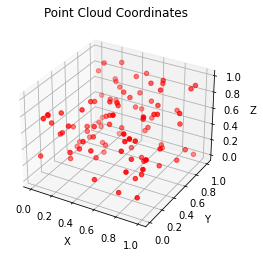

In [ ]:
#|eval: false
# Create some dummy input points
num_points = 100  # Number of points in the point cloud
points = torch.rand(num_points, num_input_features + 1)  # Random points (x, y, z, intensity)

# Visualize the input using matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot point cloud coordinates
ax.scatter(points[:, 0].numpy(), points[:, 1].numpy(), points[:, 2].numpy(), c='r', marker='o')

# Label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Title
ax.set_title('Point Cloud Coordinates')

plt.show()

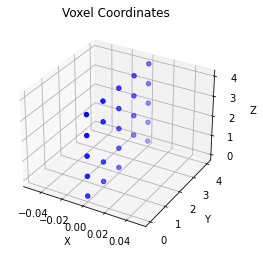

In [ ]:
#|eval: false
# Visualize the output using matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot voxel coordinates
ax.scatter(coords[:, 0].numpy(), coords[:, 1].numpy(), coords[:, 2].numpy(), c='b', marker='o')

# Label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Title
ax.set_title('Voxel Coordinates')

plt.show()

## Voxel Encoder

In [ ]:
#|export
class DynamicVoxelEncoder(nn.Module):
    """
    Dynamic version of VoxelFeatureExtractorV3
    """

    def __init__(self):
        super(DynamicVoxelEncoder, self).__init__()

    def forward(self, inputs, unq_inv):
        features = torch_scatter.scatter_mean(inputs, unq_inv, dim=0)

        return features

In [ ]:
#|export
class VoxelNet(nn.Module):
    """
    Dynamic voxelization for point clouds

    This class performs dynamic voxelization on input point clouds.
    It converts point coordinates into voxel grid coordinates and removes points that fall outside the specified range.
    """

    def __init__(self,
                voxel_size, # size of voxel
                pc_range # point cloud range
                ):
        super().__init__()
        self.voxel_size = np.array(voxel_size)
        self.pc_range = np.array(pc_range)

    def forward(self, points):
        """
        points: Tensor: (N, d), batch_id, x, y, z, ...
        """
        device = points.device

        # voxel range of x, y, z
        grid_size = (self.pc_range[3:] - self.pc_range[:3]) / self.voxel_size
        grid_size = np.round(grid_size, 0, grid_size).astype(np.int64)

        voxel_size = torch.from_numpy(
            self.voxel_size).type_as(points).to(device)
        pc_range = torch.from_numpy(self.pc_range).type_as(points).to(device)

        points_coords = (
            points[:, 1:4] - pc_range[:3].view(-1, 3)) / voxel_size.view(-1, 3)  # x, y, z

        mask = reduce(torch.logical_and, (points_coords[:, 0] >= 0,
                                          points_coords[:, 0] < grid_size[0],
                                          points_coords[:, 1] >= 0,
                                          points_coords[:, 1] < grid_size[1],
                                          points_coords[:, 2] >= 0,
                                          points_coords[:, 2] < grid_size[2]))  # remove the points out of range

        points = points[mask]
        points_coords = points_coords[mask]

        points_coords = points_coords.long()
        batch_idx = points[:, 0:1].long()
        point_index = torch.cat((batch_idx, points_coords), dim=1)

        unq, unq_inv = torch.unique(point_index, return_inverse=True, dim=0)
        unq = unq.int()

        features = points[:, 1:]

        return features, unq[:, [0, 3, 2, 1]], unq_inv, grid_size[[2, 1, 0]]

Input Points:
tensor([[0.0000, 9.5737, 0.6253, 1.6633],
        [0.0000, 2.8625, 4.7525, 7.7862],
        [0.0000, 6.9245, 7.1274, 8.3294],
        [0.0000, 4.4206, 5.2142, 2.7978],
        [0.0000, 7.7039, 3.6561, 7.8488],
        [0.0000, 9.2725, 6.5462, 8.0521],
        [0.0000, 6.3477, 1.8048, 3.3306],
        [0.0000, 7.6360, 4.3188, 3.5249],
        [0.0000, 3.8781, 0.7942, 3.1538],
        [0.0000, 3.1083, 6.7195, 1.2591]])

Features:
tensor([[9.5737, 0.6253, 1.6633],
        [2.8625, 4.7525, 7.7862],
        [6.9245, 7.1274, 8.3294],
        [4.4206, 5.2142, 2.7978],
        [7.7039, 3.6561, 7.8488],
        [9.2725, 6.5462, 8.0521],
        [6.3477, 1.8048, 3.3306],
        [7.6360, 4.3188, 3.5249],
        [3.8781, 0.7942, 3.1538],
        [3.1083, 6.7195, 1.2591]])

Voxel Coordinates:
tensor([[ 0, 15,  9,  5],
        [ 0,  2, 13,  6],
        [ 0,  6,  1,  7],
        [ 0,  5, 10,  8],
        [ 0,  6,  3, 12],
        [ 0, 16, 14, 13],
        [ 0, 15,  7, 15],
        [ 0

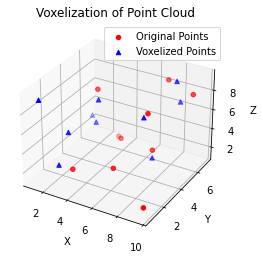

In [ ]:
#|eval: false
# Create an instance of VoxelNet
voxel_size = [0.5, 0.5, 0.5]
pc_range = [0, 0, 0, 10, 10, 10]
voxel_net = VoxelNet(voxel_size, pc_range)

# Generate synthetic point cloud data
batch_size = 1
num_points = 10
points = torch.cat((
    torch.zeros(num_points, 1),  # batch_id
    torch.rand(num_points, 3) * 10  # x, y, z
), dim=1)

# Forward pass
features, voxel_coords, unq_inv, grid_size = voxel_net(points)

# Print input and output
print("Input Points:")
print(points)
print("\nFeatures:")
print(features)
print("\nVoxel Coordinates:")
print(voxel_coords)
print("\nUnique Inverse Indices:")
print(unq_inv)
print("\nGrid Size:")
print(grid_size)

# Visual demonstration using matplotlib
# Plot original and voxelized points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 1], points[:, 2], points[:, 3], c='r', marker='o', label='Original Points')

# Convert voxel coordinates to real world coordinates
voxel_size = np.array([0.5, 0.5, 0.5])
pc_range_min = np.array([0, 0, 0])
real_coords = voxel_coords[:, 1:4].numpy() * voxel_size + pc_range_min

ax.scatter(real_coords[:, 0], real_coords[:, 1], real_coords[:, 2], c='b', marker='^', label='Voxelized Points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.title('Voxelization of Point Cloud')
plt.show()

In [ ]:
#|export
class VoxelFeatureNet(nn.Module):
    """
    This class performs dynamic voxelization of point clouds and then encodes the voxel features using DynamicVoxelEncoder.
    """
    def __init__(self,
                voxel_size, # size of voxel
                pc_range # point cloud range
                ):
        super().__init__()

        self.voxelization = VoxelNet(voxel_size, pc_range)
        self.voxel_encoder = DynamicVoxelEncoder()

    def forward(self, points):
        features, coords, unq_inv, grid_size = self.voxelization(points)

        features = self.voxel_encoder(features, unq_inv)

        return features, coords, grid_size

In [ ]:
#|eval: false
# Create an instance of VoxelFeatureNet
voxel_size = [0.1, 0.1, 0.1]
pc_range = [0, -40, -3, 70.4, 40, 1]

voxel_feature_net = VoxelFeatureNet(voxel_size, pc_range)

# Generate synthetic point cloud data
# Format: [batch_id, x, y, z, ...]
batch_size = 2
num_points = 500
num_features = 4  # x, y, z, intensity

points = torch.cat([
    torch.randint(0, batch_size, (num_points, 1)).float(),  # batch_id
    torch.rand(num_points, 3) * torch.tensor([70.4, 80, 4]) - torch.tensor([0, 40, 3]),  # x, y, z
    torch.rand(num_points, num_features - 3)  # additional features
], dim=1)

# Forward pass through the VoxelFeatureNet
features, coords, grid_size = voxel_feature_net(points)

In [ ]:
#|eval: false
#|hide
# Print the results
print("Input Points:")
print(points)
print("\nVoxel Features:")
print(features)
print("\nVoxel Coordinates:")
print(coords)
print("\nGrid Size:")
print(grid_size)

Input Points:
tensor([[ 1.0000e+00,  6.5165e+01,  2.1484e+01, -2.7179e+00,  9.9815e-02],
        [ 1.0000e+00,  6.7964e+01, -3.5975e+01, -2.9622e+00,  8.1396e-02],
        [ 1.0000e+00,  1.1408e+01, -1.0979e+01, -1.7640e+00,  3.8141e-02],
        ...,
        [ 0.0000e+00,  5.4159e+01, -1.5735e+01,  3.9104e-01,  2.8158e-01],
        [ 1.0000e+00,  1.7492e+01, -1.8973e+01, -2.8021e+00,  4.9781e-01],
        [ 1.0000e+00,  4.6789e+01, -2.4171e+01,  2.4910e-01,  6.0166e-01]])

Voxel Features:
tensor([[ 2.6307e-01, -2.4301e-01, -1.5810e+00,  6.9468e-01],
        [ 3.0147e-01,  2.9067e+01, -9.9106e-01,  5.9396e-02],
        [ 4.3795e-01, -1.0433e+01, -2.2395e+00,  5.8920e-01],
        ...,
        [ 6.9560e+01,  2.5818e-02,  6.6247e-01,  6.3107e-01],
        [ 6.9753e+01, -2.6026e+01, -2.1770e+00,  1.2989e-02],
        [ 6.9980e+01, -1.7722e+01,  5.9449e-01,  6.8002e-02]])

Voxel Coordinates:
tensor([[  0,  14, 397,   2],
        [  0,  20, 690,   3],
        [  0,   7, 295,   4],
        .

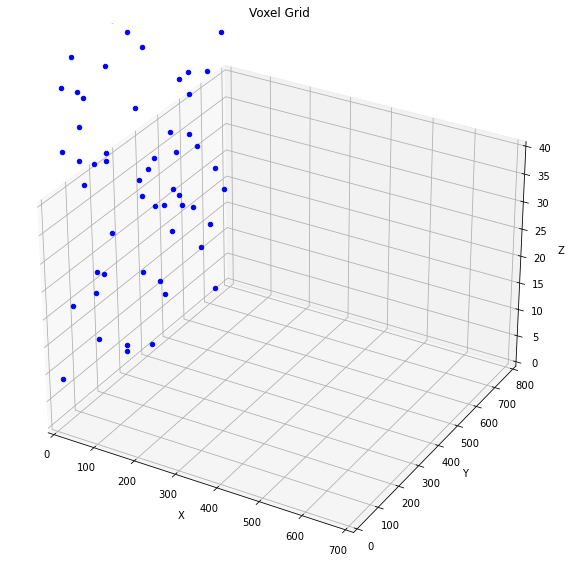

In [ ]:
#|eval: false
# Visual demonstration using matplotlib
def plot_voxel_grid(coords, grid_size):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the voxel grid
    ax.set_xlim(0, grid_size[2])
    ax.set_ylim(0, grid_size[1])
    ax.set_zlim(0, grid_size[0])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Plot the occupied voxels
    for coord in coords:
        ax.scatter(coord[1], coord[2], coord[3], c='b', marker='o')

    plt.title('Voxel Grid')
    plt.show()

# Plot the voxel grid with occupied coordinates
plot_voxel_grid(coords, grid_size)

## MVF Enconder

In [ ]:
#|export
class PointNet(nn.Module):
    """
    Linear Process for point feature
    """

    def __init__(self,
                in_channels:int, # Number of input channels
                out_channels:int # Number of output channels
                ):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels, bias=False)
        self.norm = nn.BatchNorm1d(out_channels, eps=1e-3, momentum=0.01)

    def forward(self, points):
        torch.backends.cudnn.enabled = False
        x = self.linear(points)
        x = self.norm(x)
        x = F.relu(x)
        torch.backends.cudnn.enabled = True

        return x

In [ ]:
#|export
class PillarVoxelNet(nn.Module):
    def __init__(self,
                voxel_size, # Size of voxels, only utilize x and y size
                pc_range # Point cloud range, only utilize x and y min
                ):
        super().__init__()
        self.voxel_size = np.array(voxel_size)
        self.pc_range = np.array(pc_range)

    def forward(self, points):
        device = points.device
        dtype = points.dtype

        grid_size = (self.pc_range[3:] - self.pc_range[:3]
                     )/self.voxel_size  # x,  y, z
        grid_size = np.round(grid_size, 0, grid_size).astype(np.int64)

        voxel_size = torch.from_numpy(
            self.voxel_size).type_as(points).to(device)
        pc_range = torch.from_numpy(self.pc_range).type_as(points).to(device)

        points_coords = (
            points[:, 1:4] - pc_range[:3].view(-1, 3)) / voxel_size.view(-1, 3)   # x, y, z
        points_coords[:, 0] = torch.clamp(
            points_coords[:, 0], 0, grid_size[0] - 1)
        points_coords[:, 1] = torch.clamp(
            points_coords[:, 1], 0, grid_size[1] - 1)
        points_coords[:, 2] = torch.clamp(
            points_coords[:, 2], 0, grid_size[2] - 1)

        points_coords = points_coords.long()
        batch_idx = points[:, 0:1].long()

        points_index = torch.cat((batch_idx, points_coords[:, :2]), dim=1)
        unq, unq_inv = torch.unique(points_index, return_inverse=True, dim=0)
        unq = unq.int()        # breakpoint()

        points_mean_scatter = torch_scatter.scatter_mean(
            points[:, 1:4], unq_inv, dim=0)

        f_cluster = points[:, 1:4] - points_mean_scatter[unq_inv]

        # Find distance of x, y, and z from pillar center
        f_center = points[:, 1:3] - (points_coords[:, :2].to(dtype) * voxel_size[:2].unsqueeze(0) +
                                     voxel_size[:2].unsqueeze(0) / 2 + pc_range[:2].unsqueeze(0))

        # Combine together feature decorations
        features = torch.cat([points[:, 1:], f_cluster, f_center], dim=-1)

        return features, unq[:, [0, 2, 1]], unq_inv, grid_size[[1, 0]]

In [ ]:
#|export
class CylinderNet(nn.Module):
    def __init__(self,
                voxel_size, # Size of voxels, only utilize x and y size
                pc_range # Point cloud range, only utilize x and y min
                ):
        super().__init__()
        self.voxel_size = np.array(voxel_size)
        self.pc_range = np.array(pc_range)

    def forward(self, points):
        device = points.device
        dtype = points.dtype
        points_x = points[:, 1:2]
        points_y = points[:, 2:3]
        points_z = points[:, 3:4]
        points_phi = torch.atan2(points_y, points_x) / np.pi * 180
        points_rho = torch.sqrt(points_x ** 2 + points_y ** 2)
        points_cylinder = torch.cat(
            (points[:, 0:1], points_phi, points_z, points_rho, points[:, 4:]), dim=-1)

        grid_size = (self.pc_range[3:] - self.pc_range[:3]
                     )/self.voxel_size  # phi, z, rho
        grid_size = np.round(grid_size, 0, grid_size).astype(np.int64)

        voxel_size = torch.from_numpy(
            self.voxel_size).type_as(points).to(device)
        pc_range = torch.from_numpy(self.pc_range).type_as(points).to(device)

        points_coords = (
            points_cylinder[:, 1:4] - pc_range[:3].view(-1, 3)) / voxel_size.view(-1, 3)
        points_coords[:, 0] = torch.clamp(
            points_coords[:, 0], 0, grid_size[0] - 1)
        points_coords[:, 1] = torch.clamp(
            points_coords[:, 1], 0, grid_size[1] - 1)
        points_coords[:, 2] = torch.clamp(
            points_coords[:, 2], 0, grid_size[2] - 1)
        points_coords = points_coords.long()
        batch_idx = points_cylinder[:, 0:1].long()

        points_index = torch.cat((batch_idx, points_coords[:, :2]), dim=1)
        unq, unq_inv = torch.unique(points_index, return_inverse=True, dim=0)
        unq = unq.int()

        points_mean_scatter = torch_scatter.scatter_mean(
            points_cylinder[:, 1:4], unq_inv, dim=0)
        f_cluster = points_cylinder[:, 1:4] - points_mean_scatter[unq_inv]

        # Find distance of x, y, and z from pillar center
        f_center = points_cylinder[:, 1:3] - (points_coords[:, :2].to(dtype) * voxel_size[:2].unsqueeze(0) +
                                              voxel_size[:2].unsqueeze(0) / 2 + pc_range[:2].unsqueeze(0))

        # Combine together feature decorations
        features = torch.cat(
            [points_cylinder[:, 1:], f_cluster, f_center], dim=-1)

        return features, unq[:, [0, 2, 1]], unq_inv, grid_size[[1, 0]]

In [ ]:
#|export
class SingleView(nn.Module):
    """
    authoured by Beijing-jinyu
    convolution for single view
    """

    def __init__(self,
                 in_channels,  # Number of input channels
                 num_filters,  # Number of features in each of the N PFNLayers
                 layer_nums,  # Number of blocks in each layer
                 ds_layer_strides,  # Strides of each layer
                 ds_num_filters,  # Number of features in each layer
                 kernel_size,  # Kernel size of each layer
                 mode,  # Mode of the network
                 voxel_size,  # Size of voxels, only utilize x and y size
                 pc_range,  # Point cloud range, only utilize x and y min
                 norm_cfg=None,  # Normalization config
                 act_cfg=None,  # Activation config
                 ):
        super().__init__()
        self.mode = mode
        self.voxel_size = np.array(voxel_size[:2])
        self.bias = np.array(pc_range[:2])
        num_filters = [in_channels] + list(num_filters)
        pfn_layers = []
        for i in range(len(num_filters) - 1):
            in_filters = num_filters[i]
            out_filters = num_filters[i + 1]
            if i < len(num_filters) - 2:
                last_layer = False
            else:
                last_layer = True
            pfn_layers.append(
                PFNLayer(
                    in_filters, out_filters, norm_cfg=norm_cfg, last_layer=last_layer
                )
            )
        in_filters = [num_filters[-1], *ds_num_filters[:-1]]
        self.pfn_layers = nn.ModuleList(pfn_layers)
        blocks = []
        for i, layer_num in enumerate(layer_nums):
            block = self._make_layer(
                in_filters[i],
                ds_num_filters[i],
                kernel_size[i],
                ds_layer_strides[i],
                layer_num)
            blocks.append(block)

        self.blocks = nn.ModuleList(blocks)
        self.ds_rate = np.prod(np.array(ds_layer_strides))

    def _make_layer(self, inplanes, planes, kernel_size, stride, num_blocks):

        layers = []
        layers.append(SparseConvBlock(inplanes, planes,
                      kernel_size=kernel_size, stride=stride, use_subm=False))

        for j in range(num_blocks):
            layers.append(SparseBasicBlock(planes, kernel_size=kernel_size))

        return spconv.pytorch.SparseSequential(*layers)

    def forward(self, features, unq, unq_inv, grid_size):
        feature_pos = features[:,
                               0:2] if self.mode == 'pillar' else features[:, 10:12]
        device = feature_pos.device
        voxel_size = torch.from_numpy(
            self.voxel_size).type_as(feature_pos).to(device)
        bias = torch.from_numpy(self.bias).type_as(feature_pos).to(device)
        feature_pos = (feature_pos - bias) / voxel_size

        for pfn in self.pfn_layers:
            features = pfn(features, unq_inv)  # num_points, dim_feat
        features_voxel = torch_scatter.scatter_max(features, unq_inv, dim=0)[0]
        batch_size = len(torch.unique(unq[:, 0]))
        x = spconv.pytorch.SparseConvTensor(
            features_voxel, unq, grid_size, batch_size)

        for i in range(len(self.blocks)):
            x = self.blocks[i](x)
        x = x.dense()
        feature_pos = torch.cat(
            (unq[unq_inv][:, 0:1], feature_pos / self.ds_rate), dim=-1)

        return self.bilinear_interpolate(x, feature_pos)

    def bilinear_interpolate(self, image, coords):
        """
        image: (B, C, H, W)
        coords: (N, 3): (B, y, x)
        """
        x = coords[:, 1]
        x0 = torch.floor(x).long()
        x1 = x0 + 1

        y = coords[:, 2]
        y0 = torch.floor(y).long()
        y1 = y0 + 1

        B = coords[:, 0].long()

        x0 = torch.clamp(x0, 0, image.shape[3] - 1)
        x1 = torch.clamp(x1, 0, image.shape[3] - 1)
        y0 = torch.clamp(y0, 0, image.shape[2] - 1)
        y1 = torch.clamp(y1, 0, image.shape[2] - 1)

        Ia = image[B, :, y0, x0]
        Ib = image[B, :, y1, x0]
        Ic = image[B, :, y0, x1]
        Id = image[B, :, y1, x1]

        wa = ((x1.type(torch.float32)-x) *
              (y1.type(torch.float32)-y)).unsqueeze(-1)
        wb = ((x1.type(torch.float32)-x) *
              (y-y0.type(torch.float32))).unsqueeze(-1)
        wc = ((x-x0.type(torch.float32)) *
              (y1.type(torch.float32)-y)).unsqueeze(-1)
        wd = ((x-x0.type(torch.float32)) *
              (y-y0.type(torch.float32))).unsqueeze(-1)

        features = Ia * wa + Ib * wb + Ic * wc + Id * wd

        return features

In [ ]:
#|export
class MVFFeatureNet(nn.Module):
    """
    authoured by Beijing-jinyu
    """

    def __init(self,
                in_channels, # Number of input channels
                voxel_size, # Size of voxels, only utilize x and y size
                pc_range, # Point cloud range, only utilize x and y min
                cylinder_size, # Size of cylinders, only utilize x and y size
                cylinder_range, # Cylinder range, only utilize x and y min
                num_filters, # Number of features in each of the N PFNLayers
                layer_nums, # Number of blocks in each layer
                ds_layer_strides, # Strides of each layer
                ds_num_filters, # Number of features in each layer
                kernel_size, # Kernel size of each layer
                out_channels # Number of output channels
                ):
        super().__init__()
        self.in_channels = in_channels
        self.voxel_size = voxel_size
        self.pc_range = pc_range
        self.cylinder_range = cylinder_range
        self.cylinder_size = cylinder_size

        self.voxelization = PillarVoxelNet(voxel_size, pc_range)
        self.cylinderlization = CylinderNet(cylinder_size, cylinder_range)

        self.pillarview = SingleView((in_channels + 5) * 2, num_filters, layer_nums, ds_layer_strides,
                                     ds_num_filters, kernel_size, 'pillar', self.voxel_size, self.pc_range)
        self.cylinderview = SingleView((in_channels + 5) * 2, num_filters, layer_nums, ds_layer_strides,
                                       ds_num_filters, kernel_size, 'cylinder', self.cylinder_size, self.cylinder_range)
        self.ds_rate = np.prod(np.array(ds_layer_strides))

        self.pointnet1 = PointNet((in_channels + 5) * 2, ds_num_filters[-1])
        self.pointnet2 = PointNet(ds_num_filters[-1] * 3, out_channels)

    def forward(self, points):
        dtype = points.dtype
        pc_range = torch.tensor(self.pc_range, dtype=dtype)
        mask = reduce(torch.logical_and, (points[:, 1] >= pc_range[0],
                                          points[:, 1] < pc_range[3],
                                          points[:, 2] >= pc_range[1],
                                          points[:, 2] < pc_range[4],
                                          points[:, 3] >= pc_range[2],
                                          points[:, 3] < pc_range[5]))
        points = points[mask]

        pillar_feature, pillar_coords, pillar_inv, pillar_size = self.voxelization(
            points)
        cylinder_feature, cylinder_coords, cylinder_inv, cylinder_size = self.cylinderlization(
            points)
        points_feature = torch.cat((pillar_feature, cylinder_feature), dim=-1)

        pillar_view = self.pillarview(
            points_feature, pillar_coords, pillar_inv, pillar_size)
        cylinder_view = self.cylinderview(
            points_feature, cylinder_coords, cylinder_inv, cylinder_size)

        points_feature = self.pointnet1(points_feature)
        points_feature = torch.cat(
            (points_feature, pillar_view, cylinder_view), dim=-1)
        pillar_feature = self.pointnet2(points_feature)
        pillar_feature = torch_scatter.scatter_max(
            pillar_feature, pillar_inv, dim=0)[0]
        batch_size = len(torch.unique(pillar_coords[:, 0]))
        pillar_coords[:, 1:] = pillar_coords[:, 1:] // self.ds_rate
        pillar_size = pillar_size // self.ds_rate
        x = spconv.pytorch.SparseConvTensor(
            pillar_feature, pillar_coords, pillar_size, batch_size)
        return x.dense()